https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/export/?flg=fr&sort=date&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQVZHIiwieUF4aXMiOiJ0YyIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6IiNGRjUxNUEifV0sInhBeGlzIjoiZGF0ZSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6ImRheSIsInNvcnQiOiIiLCJjb25maWciOnsiZGF0YXNldCI6ImRvbm5lZXMtc3lub3AtZXNzZW50aWVsbGVzLW9tbSIsIm9wdGlvbnMiOnsiZmxnIjoiZnIifX19XSwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&q.timerange.date=date:%5B2019-08-31T22:00:00Z+TO+2022-10-01T21:59:59Z%5D&location=2,-15.59255,38.57442&basemap=jawg.light

In [1130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [1131]:
# import wget

# site_url = 'https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/download/?format=csv&q=date:%5B2019-08-31T22:00:00Z+TO+2022-10-01T21:59:59Z%5D&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B'
# file_name = wget.download(site_url)



In [1132]:
# !mv donnees-synop-essentielles-omm.csv data_meteo.csv

In [1133]:
df = pd.read_csv('data_meteo.csv',sep=';')
df.head()

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
0,61980,2022-03-09T22:00:00+01:00,101140.0,-110.0,7.0,170.0,1.7,298.25,295.15,83.0,...,8,Sainte-Marie,97418,CA Intercommunale du Nord de la Réunion (CINOR),249740119.0,La Réunion,974,La Réunion,4.0,3
1,7577,2022-03-10T01:00:00+01:00,102530.0,40.0,0.0,0.0,0.0,277.15,275.45,89.0,...,73,Montélimar,26198,CA Montélimar Agglomération,200040459.0,Drôme,26,Auvergne-Rhône-Alpes,84.0,3
2,81415,2022-03-10T07:00:00+01:00,101200.0,130.0,7.0,0.0,0.0,295.45,295.45,100.0,...,106,Maripasoula,97353,CC de l'Ouest Guyanais,249730037.0,Guyane,973,Guyane,3.0,3
3,7240,2022-03-10T10:00:00+01:00,101970.0,40.0,1.0,130.0,4.6,283.45,278.65,72.0,...,108,Parçay-Meslay,37179,Tours Métropole Val de Loire,243700754.0,Indre-et-Loire,37,Centre-Val de Loire,24.0,3
4,7299,2022-03-10T10:00:00+01:00,102530.0,-20.0,8.0,210.0,0.6,280.85,271.35,51.0,...,263,Blotzheim,68042,CA Saint-Louis Agglomération,200066058.0,Haut-Rhin,68,Grand Est,44.0,3


In [1134]:
df.shape

(533562, 82)

In [1135]:
df['Date'] = df['Date'].astype('string')

In [1136]:
for i in range(df.shape[0]):
    df['Date'][i]=df['Date'][i][0:10]+" "+df['Date'][i][11:19]


In [1137]:
df['Date']=pd.to_datetime(df['Date'])


In [1138]:
columns = ['Date','region (name)','Température (°C)','Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']

In [1139]:
df_Date= df[columns]
df_Date.head()

,Date,region (name),Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
0,2022-03-09 22:00:00,La Réunion,25.1,101140.0,1.7,83.0,100990.0,4.5,0.2
1,2022-03-10 01:00:00,Auvergne-Rhône-Alpes,4.0,102530.0,0.0,89.0,101600.0,0.6,0.0
2,2022-03-10 07:00:00,Guyane,22.3,101200.0,0.0,100.0,99970.0,NaN,0.0
3,2022-03-10 10:00:00,Centre-Val de Loire,10.3,101970.0,4.6,72.0,100610.0,6.8,0.0
4,2022-03-10 10:00:00,Grand Est,7.7,102530.0,0.6,51.0,99200.0,2.0,0.0


In [1140]:
df_Date = df_Date.dropna()
df_Date.shape

(388387, 9)

In [1141]:
df_region = df_Date

In [1142]:
df_Date.set_index('Date', inplace = True)
df_Date.head()

,region (name),Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
Date,,,,,,,,
2022-03-09 22:00:00,La Réunion,25.1,101140.0,1.7,83.0,100990.0,4.5,0.2
2022-03-10 01:00:00,Auvergne-Rhône-Alpes,4.0,102530.0,0.0,89.0,101600.0,0.6,0.0
2022-03-10 10:00:00,Centre-Val de Loire,10.3,101970.0,4.6,72.0,100610.0,6.8,0.0
2022-03-10 10:00:00,Grand Est,7.7,102530.0,0.6,51.0,99200.0,2.0,0.0
2022-03-10 10:00:00,Nouvelle-Aquitaine,11.1,101890.0,3.3,88.0,101610.0,6.6,0.0


In [1143]:
df_Date = df_Date.groupby(by=['Date']).mean()

df_Date.head()

/var/folders/30/qyvjf51j20q5ybc7cqckcgnm0000gn/T/ipykernel_29603/4196980697.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_Date = df_Date.groupby(by=['Date']).mean()


,Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
Date,,,,,,,
2019-09-01 02:00:00,18.779070,101606.511628,2.655814,75.906977,100039.069767,5.453488,0.023256
2019-09-01 05:00:00,16.930233,101583.255814,2.432558,79.465116,99999.534884,4.776744,0.039535
2019-09-01 08:00:00,16.990476,101644.285714,2.630952,81.214286,100029.047619,4.614286,0.100000
2019-09-01 11:00:00,20.011111,101706.222222,3.357778,68.222222,100197.111111,6.155556,0.028889
2019-09-01 14:00:00,22.506818,101712.954545,3.786364,58.022727,100225.909091,6.979545,0.034091


In [1144]:
df_Date.shape

(9012, 7)

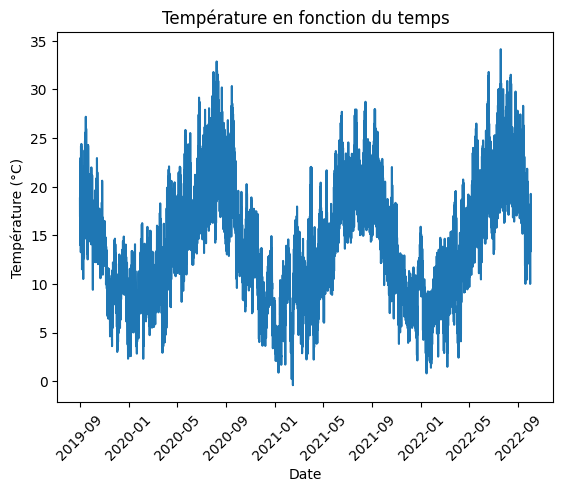

In [1145]:
plt.plot(df_Date.index,df_Date['Température (°C)'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.title('Température en fonction du temps')
plt.show()

In [1146]:
df_region = df_region.groupby(by=['Date','region (name)']).mean()
df_region.head()

Température (°C)  \
Date                region (name)                               
2019-09-01 02:00:00 Auvergne-Rhône-Alpes            21.733333   
                    Bourgogne-Franche-Comté         23.000000   
                    Bretagne                        13.300000   
                    Centre-Val de Loire             17.950000   
                    Corse                           22.050000   

                                             Pression au niveau mer  \
Date                region (name)                                     
2019-09-01 02:00:00 Auvergne-Rhône-Alpes              101526.666667   
                    Bourgogne-Franche-Comté           101430.000000   
                    Bretagne                          101907.500000   
                    Centre-Val de Loire               101650.000000   
                    Corse                             101355.000000   

                                             Vitesse du vent moyen 10 mn  \
Date                region (name)                                          
2019-09-01 02:00:00 Auvergne-Rhône-Alpes                        1.433333   
                    Bourgogne-Franche-Comté                     3.000000   
                    Bretagne                                    2.700000   
                    Centre-Val de Loire                         2.400000   
                    Corse                                       3.000000   

                                             Humidité  Pression station  \
Date                region (name)                                         
2019-09-01 02:00:00 Auvergne-Rhône-Alpes        73.00      99076.666667   
                    Bourgogne-Franche-Comté     49.00      98830.000000   
                    Bretagne                    85.25     101195.000000   
                    Centre-Val de Loire         68.50     100020.000000   
                    Corse                       72.50     101235.000000   

                                             Rafales sur une période  \
Date                region (name)                                      
2019-09-01 02:00:00 Auvergne-Rhône-Alpes                    3.833333   
                    Bourgogne-Franche-Comté                 5.900000   
                    Bretagne                                5.225000   
                    Centre-Val de Loire                     4.900000   
                    Corse                                   4.400000   

                                             Précipitations dans les 3 dernières heures  
Date                region (name)                                                        
2019-09-01 02:00:00 Auvergne-Rhône-Alpes                                       0.366667  
                    Bourgogne-Franche-Comté                                    0.000000  
                    Bretagne                                                   0.000000  
                    Centre-Val de Loire                                        0.000000  
                    Corse                                                      0.000000

In [1147]:
df_region = df_region.reset_index(level=['Date','region (name)'])
df_region['region (name)'] = df_region['region (name)'].astype('string')
df_region

,Date,region (name),Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
0,2019-09-01 02:00:00,Auvergne-Rhône-Alpes,21.733333,101526.666667,1.433333,73.00,99076.666667,3.833333,0.366667
1,2019-09-01 02:00:00,Bourgogne-Franche-Comté,23.000000,101430.000000,3.000000,49.00,98830.000000,5.900000,0.000000
2,2019-09-01 02:00:00,Bretagne,13.300000,101907.500000,2.700000,85.25,101195.000000,5.225000,0.000000
3,2019-09-01 02:00:00,Centre-Val de Loire,17.950000,101650.000000,2.400000,68.50,100020.000000,4.900000,0.000000
4,2019-09-01 02:00:00,Corse,22.050000,101355.000000,3.000000,72.50,101235.000000,4.400000,0.000000
...,...,...,...,...,...,...,...,...,...
158530,2022-10-01 23:00:00,Pays de la Loire,17.400000,102200.000000,4.500000,96.00,101890.000000,10.000000,-0.100000
158531,2022-10-01 23:00:00,Provence-Alpes-Côte d'Azur,18.500000,102165.000000,3.400000,78.50,101820.000000,5.200000,0.000000
158532,2022-10-01 23:00:00,Saint-Pierre-et-Miquelon,12.200000,101570.000000,8.000000,90.00,101490.000000,12.300000,0.000000
158533,2022-10-01 23:00:00,Terres australes et antarctiques françaises,-0.300000,101500.000000,3.600000,79.00,101120.000000,5.700000,0.000000


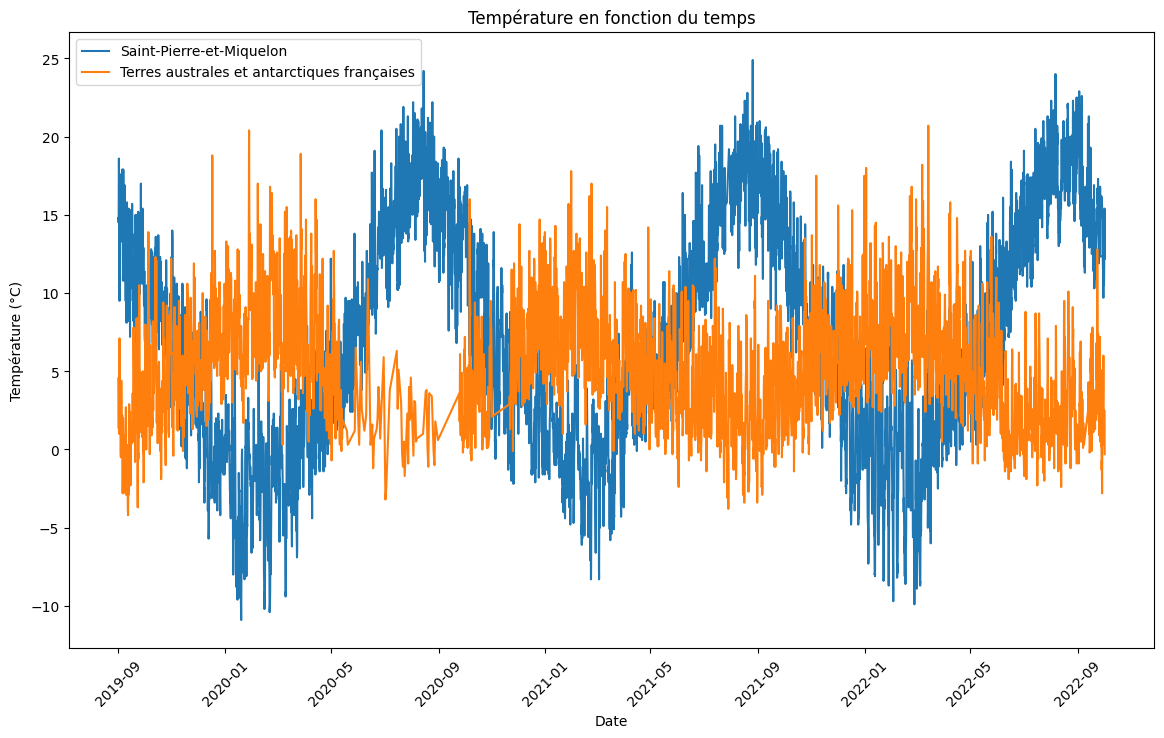

In [1148]:
plt.figure(figsize=(14,8))

for region in ['Saint-Pierre-et-Miquelon','Terres australes et antarctiques françaises']:
    df_temporaire = df_region[df_region['region (name)']== region]
    plt.plot(df_temporaire['Date'],df_temporaire['Température (°C)'])
    plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.title('Température en fonction du temps')
plt.legend(['Saint-Pierre-et-Miquelon','Terres australes et antarctiques françaises'])
plt.show()
del df_temporaire


# Trouver la périodicité

Nous pouvons imaginer une saisonalité de 1 ans soit 365 * 24 / 3 = 2920 car nous avons un relevé de données toutes les 3 heures.

Vérifions ça.

In [1149]:
df_temporaire = pd.DataFrame(df_Date.index.astype('string'))
for year in range (df_temporaire.shape[0]):
    df_temporaire['Date'][year] = df_temporaire['Date'][year][0:4]

df_temporaire['Date'].value_counts()


2020    2926
2021    2918
2022    2192
2019     976
Name: Date, dtype: Int64

# Décomposition STL

In [1150]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

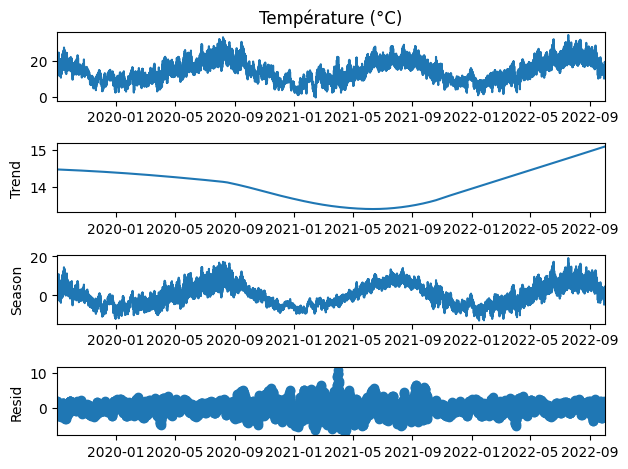

In [1151]:
result = STL(df_Date['Température (°C)'], period=2920).fit()

_ = result.plot()

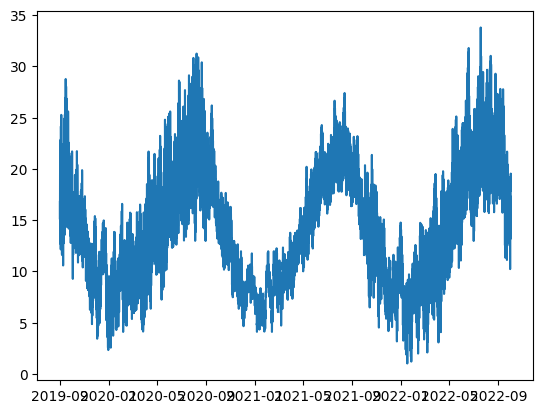

In [1152]:
plt.plot(result.seasonal+result.trend)

# NaiveForcaster
## Avec la database sur la moyenne des températures sur le territoire Français
### Réalisé uniquement avec les données de températures

In [1153]:
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import smape_loss
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
from sktime.utils.plotting import plot_series

def plot_ys(*args, **kwargs):
    # restore previous behaviour (jfb)
    nb_series=len(args)
    plot_series(*args, **kwargs, markers=['' for k in range(nb_series)])

7012 2000


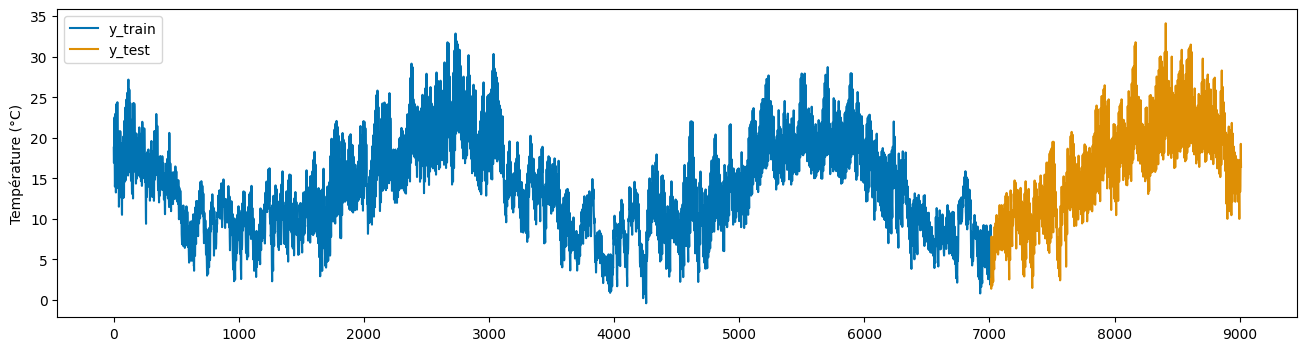

In [1154]:
y = pd.Series(data=df_Date['Température (°C)'].reset_index(drop=True)) #index=t[1:],
y_train, y_test = temporal_train_test_split(y, test_size=2000)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [1155]:
fh = np.arange(1,len(y_test)+1) 


In [1156]:
# Pour limiter le nombre de points, on ne prend que les 200 derniers
y_train = y_train[-4000:]


30 2.8354244379702194
1000 1.169750889473684
2000 0.9271342668021557
2500 0.401103128228619
2900 0.3792963625736007
2910 0.26691387467770145
2920 0.42270482108678165
la valeur la plus faible en loss correspond à une saisonalité de :  2910


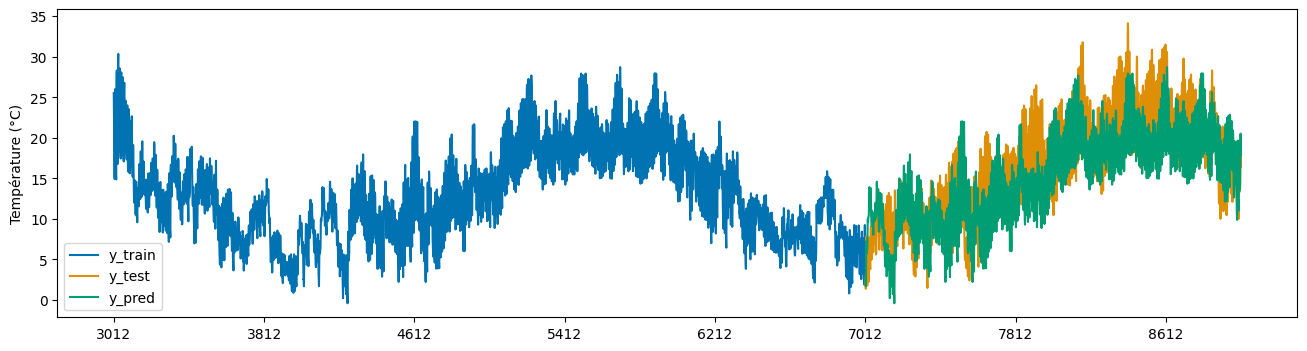

In [1157]:
# using sktime 
res = []
val = [30,1000, 2000, 2500,2900,2910, 2920]
from sktime.forecasting.naive import NaiveForecaster
for i in val:
    forecaster = NaiveForecaster(strategy="last",sp=i)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    res.append(smape_loss(y_pred, y_test))
    print(i,res[-1])
saisonalite = val[res.index(min(res))]

print("la valeur la plus faible en loss correspond à une saisonalité de : ",saisonalite)

forecaster = NaiveForecaster(strategy="last",sp=saisonalite)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
smape_loss(y_pred, y_test)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
